
# Image denoising using dictionary learning

An example comparing the effect of reconstructing noisy fragments
of a raccoon face image using firstly online `DictionaryLearning` and
various transform methods.

The dictionary is fitted on the distorted left half of the image, and
subsequently used to reconstruct the right half. Note that even better
performance could be achieved by fitting to an undistorted (i.e.
noiseless) image, but here we start from the assumption that it is not
available.

A common practice for evaluating the results of image denoising is by looking
at the difference between the reconstruction and the original image. If the
reconstruction is perfect this will look like Gaussian noise.

It can be seen from the plots that the results of `omp` with two
non-zero coefficients is a bit less biased than when keeping only one
(the edges look less prominent). It is in addition closer from the ground
truth in Frobenius norm.

The result of `least_angle_regression` is much more strongly biased: the
difference is reminiscent of the local intensity value of the original image.

Thresholding is clearly not useful for denoising, but it is here to show that
it can produce a suggestive output with very high speed, and thus be useful
for other tasks such as object classification, where performance is not
necessarily related to visualisation.


## Generate distorted image



In [1]:
import numpy as np

try:  # Scipy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

raccoon_face = face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
raccoon_face = raccoon_face / 255.0

# downsample for higher speed
raccoon_face = (
    raccoon_face[::4, ::4]
    + raccoon_face[1::4, ::4]
    + raccoon_face[::4, 1::4]
    + raccoon_face[1::4, 1::4]
)
raccoon_face /= 4.0
height, width = raccoon_face.shape

# Distort the right half of the image
print("Distorting image...")
distorted = raccoon_face.copy()
distorted[:, width // 2 :] += 0.075 * np.random.randn(height, width // 2)

Distorting image...


## Display the distorted image



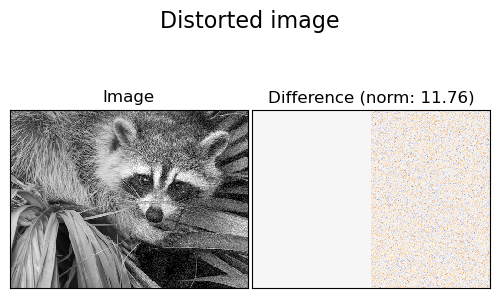

In [2]:
import matplotlib.pyplot as plt


def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
    plt.imshow(
        difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, raccoon_face, "Distorted image")

## Extract reference patches



In [12]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d

# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, : width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))

Extracting reference patches...
22692 patches extracted in 0.02s.


## Learn the dictionary from reference patches



Learning the dictionary...
2.0 iterations / 87 steps in 6.55.


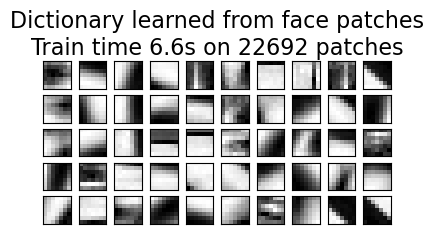

In [15]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=300,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_
dt = time() - t0
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

## Extract noisy patches and reconstruct them using the dictionary



Extracting noisy patches... 
done in 0.01s.
Orthogonal Matching Pursuit
1 atom...
done in 0.83s.
Orthogonal Matching Pursuit
2 atoms...
done in 1.69s.
Least-angle regression
4 atoms...
done in 14.08s.
Thresholding
 alpha=0.1...
done in 0.11s.


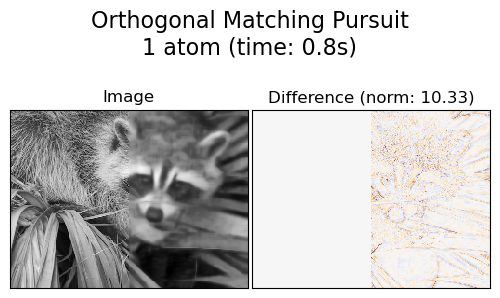

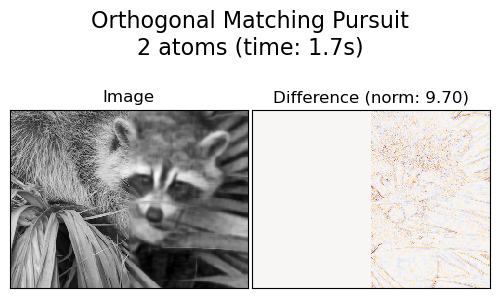

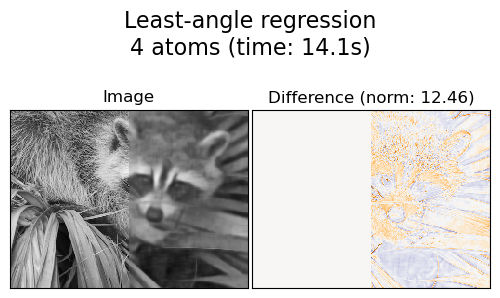

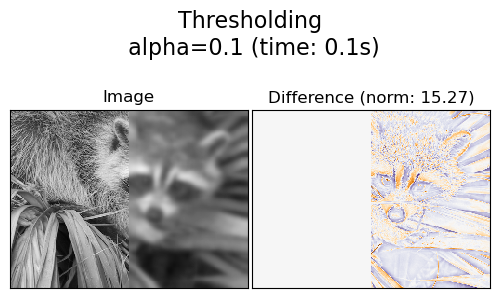

In [17]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print("Extracting noisy patches... ")
t0 = time()
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = raccoon_face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], raccoon_face, title + " (time: %.1fs)" % dt)

plt.show()